# Richards model prediction of Covid-19 for Cuba

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # plots
import pymc3 as pm
import arviz as az

## Load data

In [3]:
# Global parameters
country = 'Cuba'
ndays_limit = 68
epidemic_start = 10
x_data_label = 'days_since_{}'.format(epidemic_start)

# loading data
oper_file_path1 = 'data/cuba_data.csv'
df_input = pd.read_csv(oper_file_path1, sep=',', decimal='.', error_bad_lines=False, parse_dates=['date'])
df_input.index = df_input['date']

# Prepare data for model training
df = df_input[df_input['confirmed'] > epidemic_start][['date', 'confirmed', 'new_cases']].copy()
df.columns = ['date', 'acumulado', 'new_cases']
df[x_data_label] = list(np.arange(df.shape[0]))
print(df.tail(10))

                 date  acumulado  new_cases  days_since_10
date                                                      
2020-05-18 2020-05-18       1887          6             61
2020-05-19 2020-05-19       1900         13             62
2020-05-20 2020-05-20       1908          8             63
2020-05-21 2020-05-21       1916          8             64
2020-05-22 2020-05-22       1931         15             65
2020-05-23 2020-05-23       1941         10             66
2020-05-24 2020-05-24       1947          6             67
2020-05-25 2020-05-25       1963         16             68
2020-05-26 2020-05-26       1974         11             69
2020-05-27 2020-05-27       1983          9             70


## Split data into: train and test

In [5]:
df_train = df.loc['2020-03-18':'2020-05-24']
df_test = df.loc['2020-05-25':'2020-05-27']
df_test

,date,acumulado,new_cases,days_since_10
date,,,,
2020-05-25,2020-05-25,1963,16,68
2020-05-26,2020-05-26,1974,11,69
2020-05-27,2020-05-27,1983,9,70


## Model fit

In [6]:
x_values = df_train[x_data_label].values
y_values = df_train.acumulado.astype('float64').values
dt_until = str(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]).replace('-', '')
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -284.29, ||grad|| = 15.755: 100%|██████████| 65/65 [00:00<00:00, 2530.65it/s]       
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:10<00:00, 293.81draws/s]
The acceptance probability does not match the target. It is 0.8818088994224695, but should be close to 0.95. Try to increase the number of tuning steps.


## Model summary

In [7]:
az.summary(az.from_pymc3(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rate,0.283,0.024,0.239,0.329,0.000,0.000,8737.0,8694.0,8825.0,10480.0,1.0
sigma[0],0.007,0.001,0.005,0.009,0.000,0.000,16502.0,16306.0,16488.0,15983.0,1.0
K,2006.349,7.497,1992.179,2020.319,0.068,0.048,12113.0,12113.0,12115.0,14409.0,1.0
a,0.301,0.031,0.245,0.360,0.000,0.000,8737.0,8737.0,8734.0,10753.0,1.0
x0,27.294,0.168,26.980,27.610,0.002,0.001,9809.0,9809.0,9813.0,12456.0,1.0
T,2.009,0.575,1.078,2.949,0.004,0.003,21191.0,20844.0,20112.0,13701.0,1.0
R0,1.791,0.307,1.300,2.306,0.002,0.002,19206.0,18803.0,18670.0,14916.0,1.0


In [8]:
pm.backends.tracetab.trace_to_dataframe(trace)

,rate,sigma__0,K,a,x0,T,R0
0,0.309977,0.004893,2017.381657,0.265557,27.227843,2.715204,2.320196
1,0.290510,0.005700,2014.243188,0.285918,27.221430,2.177368,1.882401
2,0.287478,0.009471,2000.139489,0.295134,27.247590,2.259066,1.914452
3,0.295227,0.008138,2018.288059,0.279835,27.313227,1.418637,1.520167
4,0.260705,0.008567,1994.140662,0.331033,27.337730,1.542317,1.494946
...,...,...,...,...,...,...,...
27995,0.318058,0.004701,2021.928348,0.256862,27.131404,1.352666,1.537606
27996,0.299170,0.010219,2002.218431,0.281329,27.176180,2.555476,2.147965
27997,0.242198,0.006563,2004.827907,0.356552,27.595879,1.819639,1.553815
27998,0.252440,0.007785,2008.187989,0.337291,27.642404,2.758336,2.006347


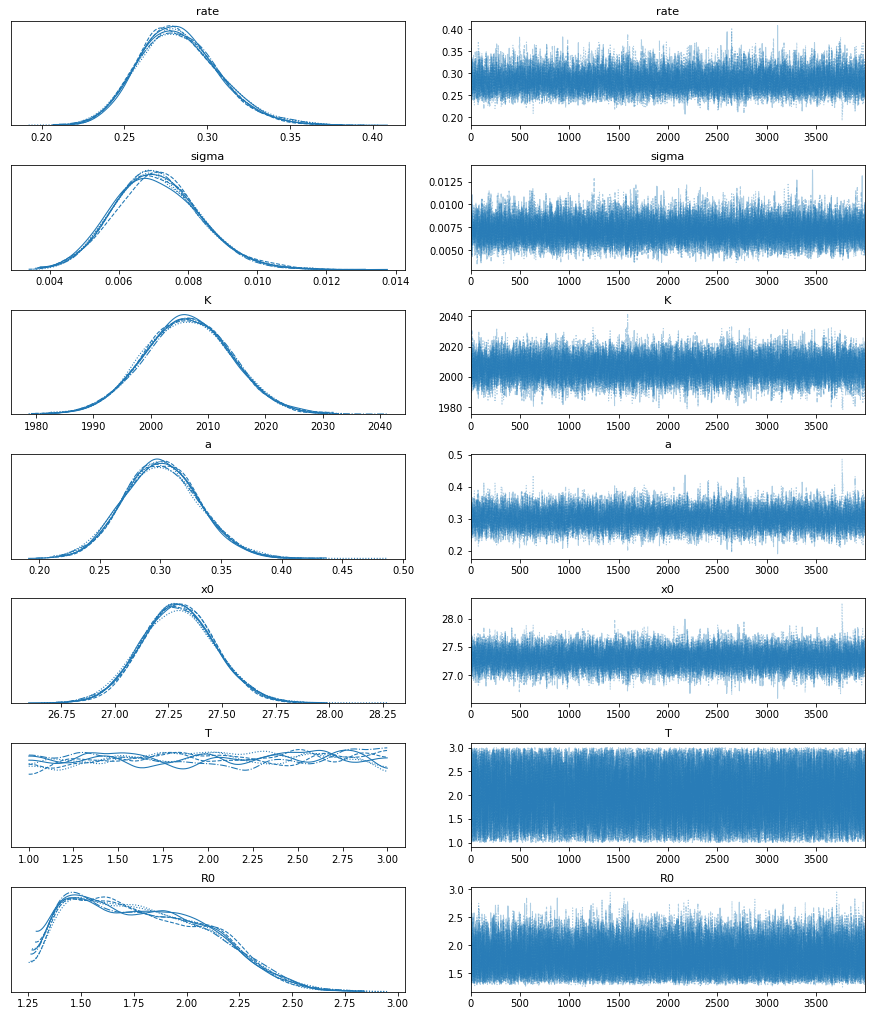

In [9]:
az.plot_trace(trace, compact=True);

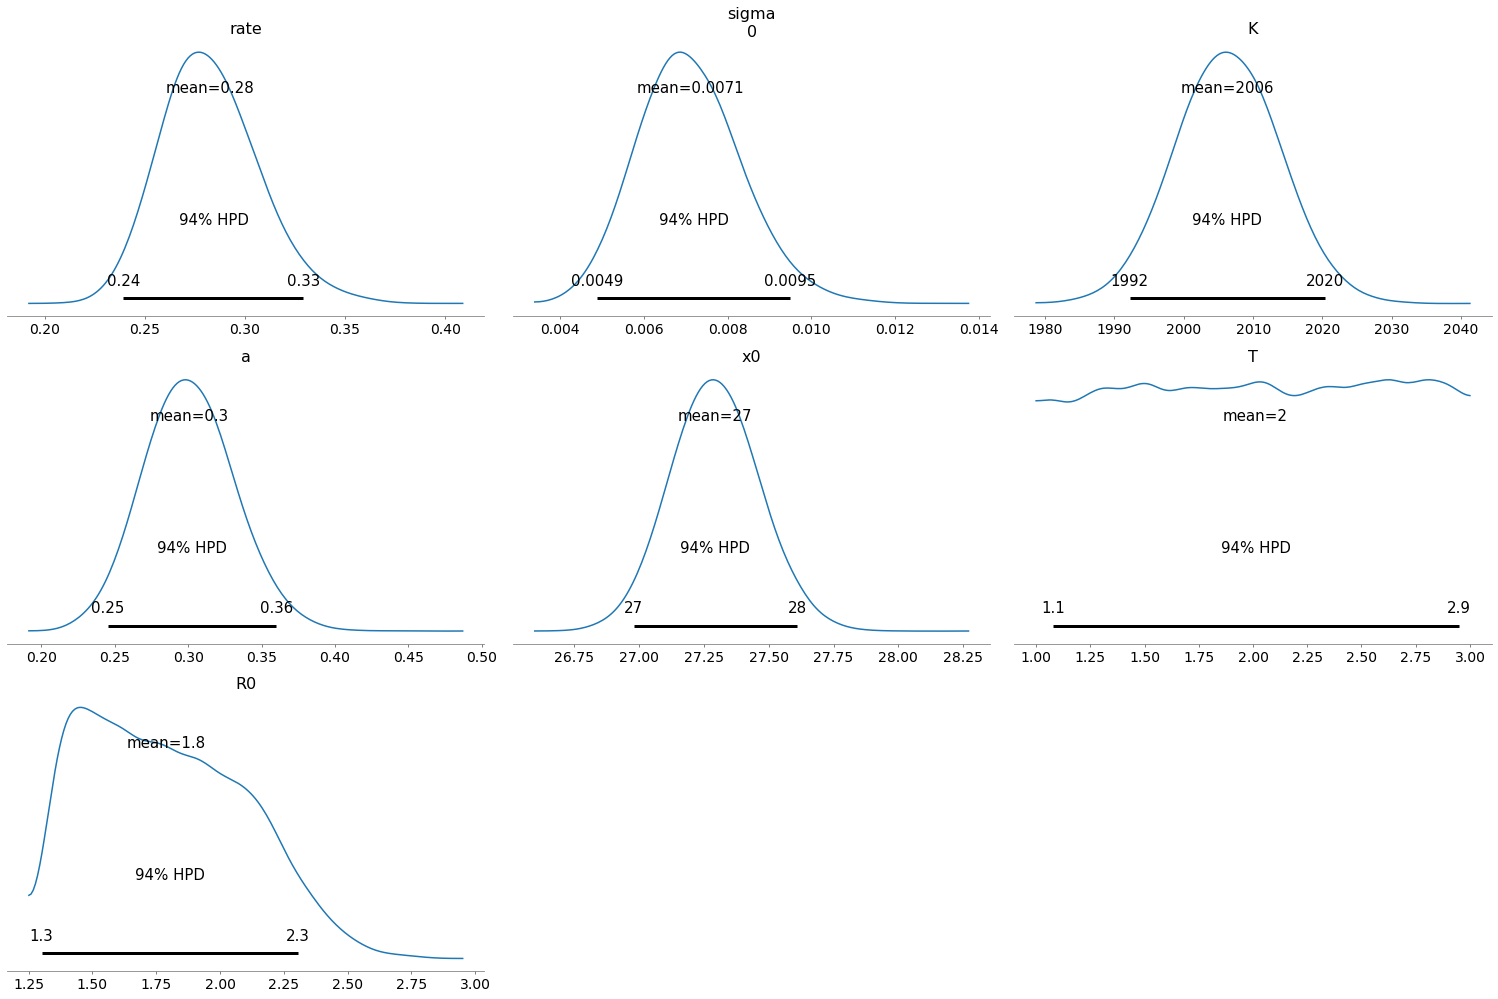

In [10]:
az.plot_posterior(trace);

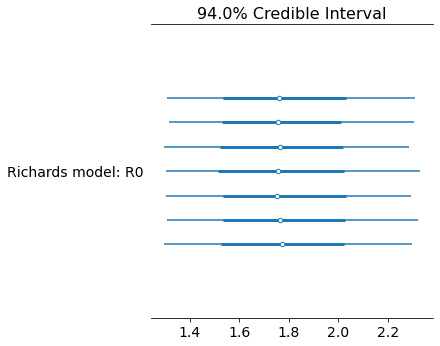

In [11]:
az.plot_forest([trace], model_names=["Richards model"], var_names=['R0']);

In [12]:
# Fitted parameters
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
txt = """
        --------------------------------------
        Fitted parameters for {}:
        --------------------------------------
        Growth rate: {}
        Turning point: {}
        Final size of epidemic: {}
        Basic reproduction number (R0): {}
        --------------------------------------
     """.format(country, *f_values)
print(txt)


        --------------------------------------
        Fitted parameters for Cuba:
        --------------------------------------
        Growth rate: 0.28
        Turning point: 27.29
        Final size of epidemic: 2006.35
        Basic reproduction number (R0): 1.79
        --------------------------------------
     


## Model predictions

In [13]:
# ========== Compute predictions =============
np.random.seed(12345)
tp = int(round(np.percentile(trace['x0'], 50, axis=0)))
h = tp # 27  # number points to prediction ahead
with richards_model:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, len(y_values) + h)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({"x_data": x_data})
    pm.set_data({"y_data": y_data})

    # Sample posterior predictive
    post_pred_final = pm.sample_posterior_predictive(trace, samples=100)

# Prediction of cumulative cases 
y_min_final = np.percentile(post_pred_final['y'], 2.5, axis=0)
y_max_final = np.percentile(post_pred_final['y'], 97.5, axis=0)
y_fit_final = np.percentile(post_pred_final['y'], 50, axis=0)

# Prediction of incidence of new cases
dy_fit_final = np.percentile(trace['rate'], 50, axis=0) * y_fit_final * (1 - (y_fit_final / np.percentile(trace['K'], 50, axis=0)) ** np.percentile(trace['a'], 50, axis=0))

/home/jrd/.local/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 139.32it/s]


In [14]:
from sklearn.metrics import mean_squared_error
rms_train = round(np.sqrt(mean_squared_error(df_train['acumulado'], y_fit_final[df_train[x_data_label]])),2)
rms_test = round(np.sqrt(mean_squared_error(df_test['acumulado'], y_fit_final[df_test[x_data_label]])),2)
print('RMSE-train: {}'.format(rms_train))
print('RMSE-test: {}'.format(rms_test))

RMSE-train: 11.51
RMSE-test: 27.12


### Plot prediction of comulative cases

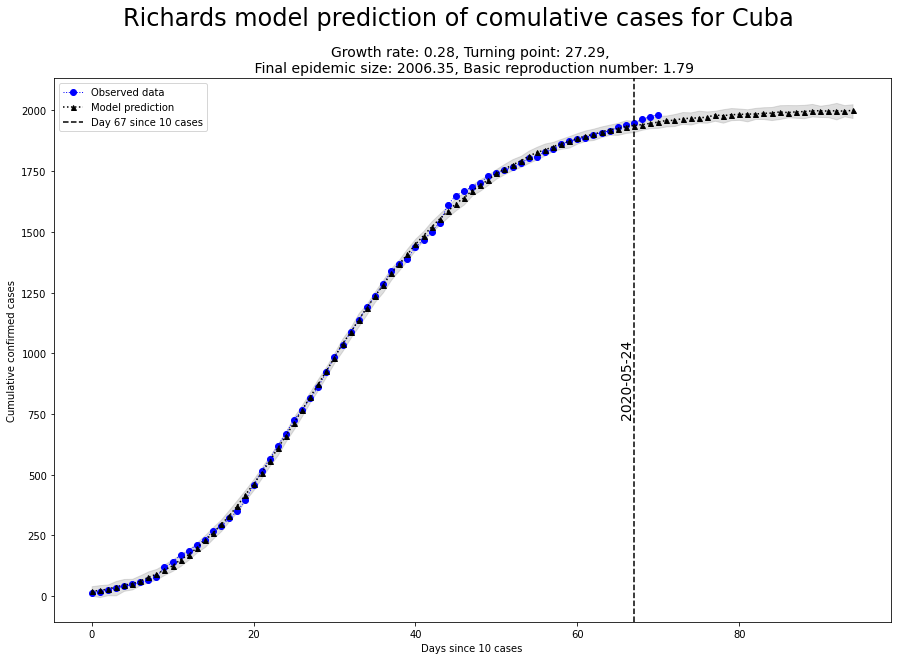

In [15]:
# Plot prediction of comulative cases
#ymax_limit = max(max(y_fit_final), df.acumulado.astype('float64').max()) * 1.10
yref_ycoord_0 = min(np.median(y_fit_final), df.acumulado.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['acumulado'], 'b', marker='o', ls=':', lw=1, label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), y_fit_final,
         'k', marker='^', ls=':', ms=5, mew=1, label='Model prediction')
plt.fill_between(np.arange(0, post_pred_final['y'].shape[1]), y_min_final, y_max_final, color='0.5', alpha=0.25)
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df_train[df_train[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
plt.suptitle('Richards model prediction of comulative cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
ax.set(xlabel='Days since {} cases'.format(epidemic_start))
ax.set(ylabel='Cumulative confirmed cases')
plt.legend(loc='upper left')
# plt.savefig('results/{}/cumulative_prediction_plot.png'.format(country))
plt.show()

### Plot prediction of incidence of new cases

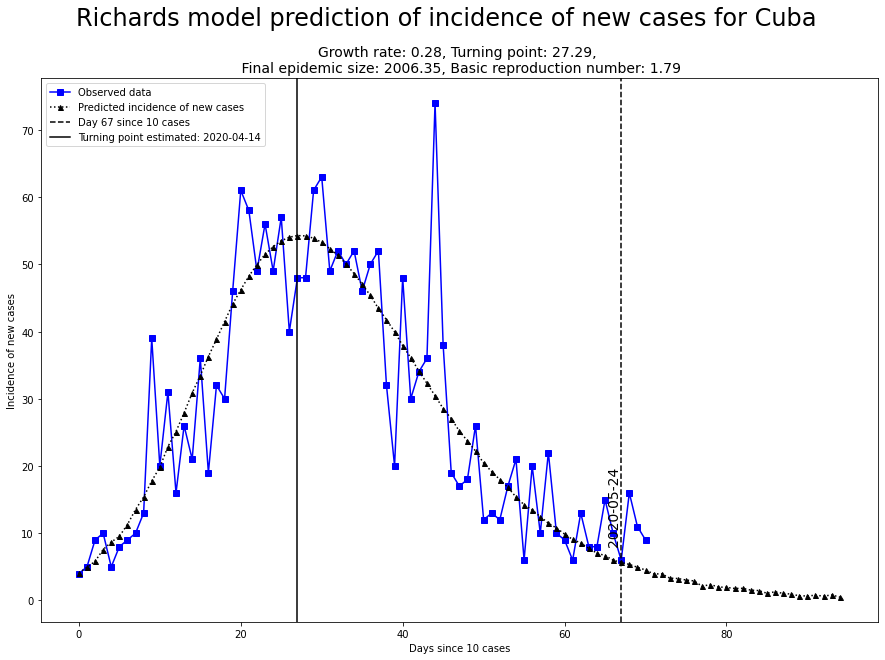

In [16]:
# Incidence of new cases prediction
yref_ycoord_0 = min(np.median(dy_fit_final), df.new_cases.median()) * 0.6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(df[x_data_label], df['new_cases'], 'b', marker='s', ls='-', label='Observed data')
plt.plot(np.arange(0, post_pred_final['y'].shape[1]), dy_fit_final, 'k', marker='^', ls=':', ms=5, mew=1,
         label='Predicted incidence of new cases')
ax.axvline(x_values[-1], ls='--', color='k', label='Day {} since {} cases'.format(x_values[-1],epidemic_start))
plt.text(x_values[-1], yref_ycoord_0,
         "{}".format(df[df[x_data_label] == x_values[-1]].date.map(lambda x: str(x)[:10]).values[0]),
         {'color': 'k', 'fontsize': 14},
         horizontalalignment='right', verticalalignment='baseline', rotation=90, clip_on=False)
if tp in list(df[x_data_label].values):
    tp_date = df[df[x_data_label] == tp].date.values[0]
    ax.axvline(tp, ls='-', color='k', label='Turning point estimated: {}'.format(str(tp_date)[:10]))
plt.xlabel('Days since {} cases'.format(epidemic_start))
plt.ylabel('Incidence of new cases')
plt.suptitle('Richards model prediction of incidence of new cases for {}'.format(country), fontsize=24)
f_values = (round(trace['rate'].mean(), 2), round(trace['x0'].mean(), 2),
            round(trace['K'].mean(), 2), round(trace['R0'].mean(), 2))
plt.title('Growth rate: {}, Turning point: {}, \n Final epidemic size: {}, Basic reproduction number: {}'.format(*f_values), fontsize=14)
plt.legend(loc='upper left')
# plt.savefig('results/{}/newcases_prediction_plot.png'.format(country))
plt.show()

## Refit the model with full data

In [17]:
x_values = df[x_data_label].values
y_values = df.acumulado.astype('float64').values
with pm.Model() as richards_model:
    sigma = pm.HalfCauchy('sigma', 1, shape=1)
    K = pm.Uniform('K', 100, 1000000, testval=5000)  # carrying capacity
    rate = pm.Normal('rate', 0.3, 0.05, testval=0.45)  # growth rate
    a = pm.Uniform('a', 0.1, 10.0, testval=0.25)
    x0 = pm.Uniform('x0', 1, 200, testval=15)
    T = pm.Uniform('T', 1, 3, testval=1.2)
    R0 = pm.Deterministic('R0', np.exp(rate * T))

    # Create likelihood for data
    x_data = pm.Data("x_data", x_values)
    y_data = pm.Data("y_data", y_values)
    mu = K * (1 + np.exp(-rate * a * (x_data - x0 - (np.log(a) / (rate * a))))) ** (-1 / a)
    y = pm.Normal('y', mu=mu, tau=sigma, observed=y_data)
    
with richards_model:
    
    # Sample posterior
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(4000, tune=4000, cores=7, start=start, target_accept=.95, random_seed=1234)

logp = -299.52, ||grad|| = 0.045592: 100%|██████████| 63/63 [00:00<00:00, 2665.33it/s]     
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (7 chains in 7 jobs)
NUTS: [T, x0, a, rate, K, sigma]
Sampling 7 chains, 0 divergences: 100%|██████████| 56000/56000 [03:07<00:00, 299.09draws/s]


## Save the model for further analysis

In [18]:
import pickle 

with open('results/Cuba/model_data.pkl', 'wb') as buff:
    pickle.dump({'model': richards_model, 'trace': trace}, buff)